In [13]:
import sys
import os
import timm
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from torchvision import transforms
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
# Get the path to the directory containing the notebook and the src folder
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)

# Add the src directory to sys.path
src_dir = os.path.join(project_dir, 'src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

from data import ChestXray14Dataset, build_transform_classification
from trainers import MultiLabelLightningModule

In [3]:
path_to_labels = '/cluster/home/taheeraa/code/BenchmarkTransformers/dataset'
file_path_train = path_to_labels + '/Xray14_train_official.txt'
file_path_val = path_to_labels + '/Xray14_val_official.txt'
file_path_test = path_to_labels + '/Xray14_test_official.txt'
checkpoint_path = '/cluster/home/taheeraa/code/BenchmarkTransformers/Models/Classification/ChestXray14/swin_base_simmim/swin_base_simmim_run_0.pth.tar'

data_path = '/cluster/home/taheeraa/datasets/chestxray-14'
images_path = data_path + '/images'

num_workers = 4
pin_memory = False

num_labels = 14
batch_size = 32
learning_rate = 0.01
img_size = 224

labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia"
]

In [4]:
# imagenet
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# cxr
normalize = transforms.Normalize(
    [0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])

test_transforms = transforms.Compose([
    transforms.Resize(
        (img_size, img_size), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    normalize,
])


In [5]:
test_dataset = ChestXray14Dataset(images_path=images_path, file_path=file_path_test,
                                  augment=test_transforms, num_class=num_labels)


In [6]:
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [7]:
model = timm.create_model(
            'swin_base_patch4_window7_224', num_classes=num_labels)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10)

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
checkpoint = torch.load(checkpoint_path)
ckpt_state_dict = checkpoint['state_dict']
#incompatiable_keys = training_module.load_state_dict(ckpt_state_dict, strict=False)
model.load_state_dict(ckpt_state_dict)

<All keys matched successfully>

In [ ]:
model.eval()

predictions = []
all_labels = [] 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

for batch in tqdm(test_loader, desc="Processing batches"):
    pixel_values = batch['pixel_values'].to(device)
    targets = batch['labels'].to(device)
    
    with torch.no_grad():
        outputs = model(pixel_values)
        predicted = torch.sigmoid(outputs).cpu().numpy() > 0.5
        predictions.append(predicted)
        all_labels.append(targets.cpu().numpy())

In [21]:
predictions = np.vstack(predictions)
all_labels = np.vstack(all_labels)

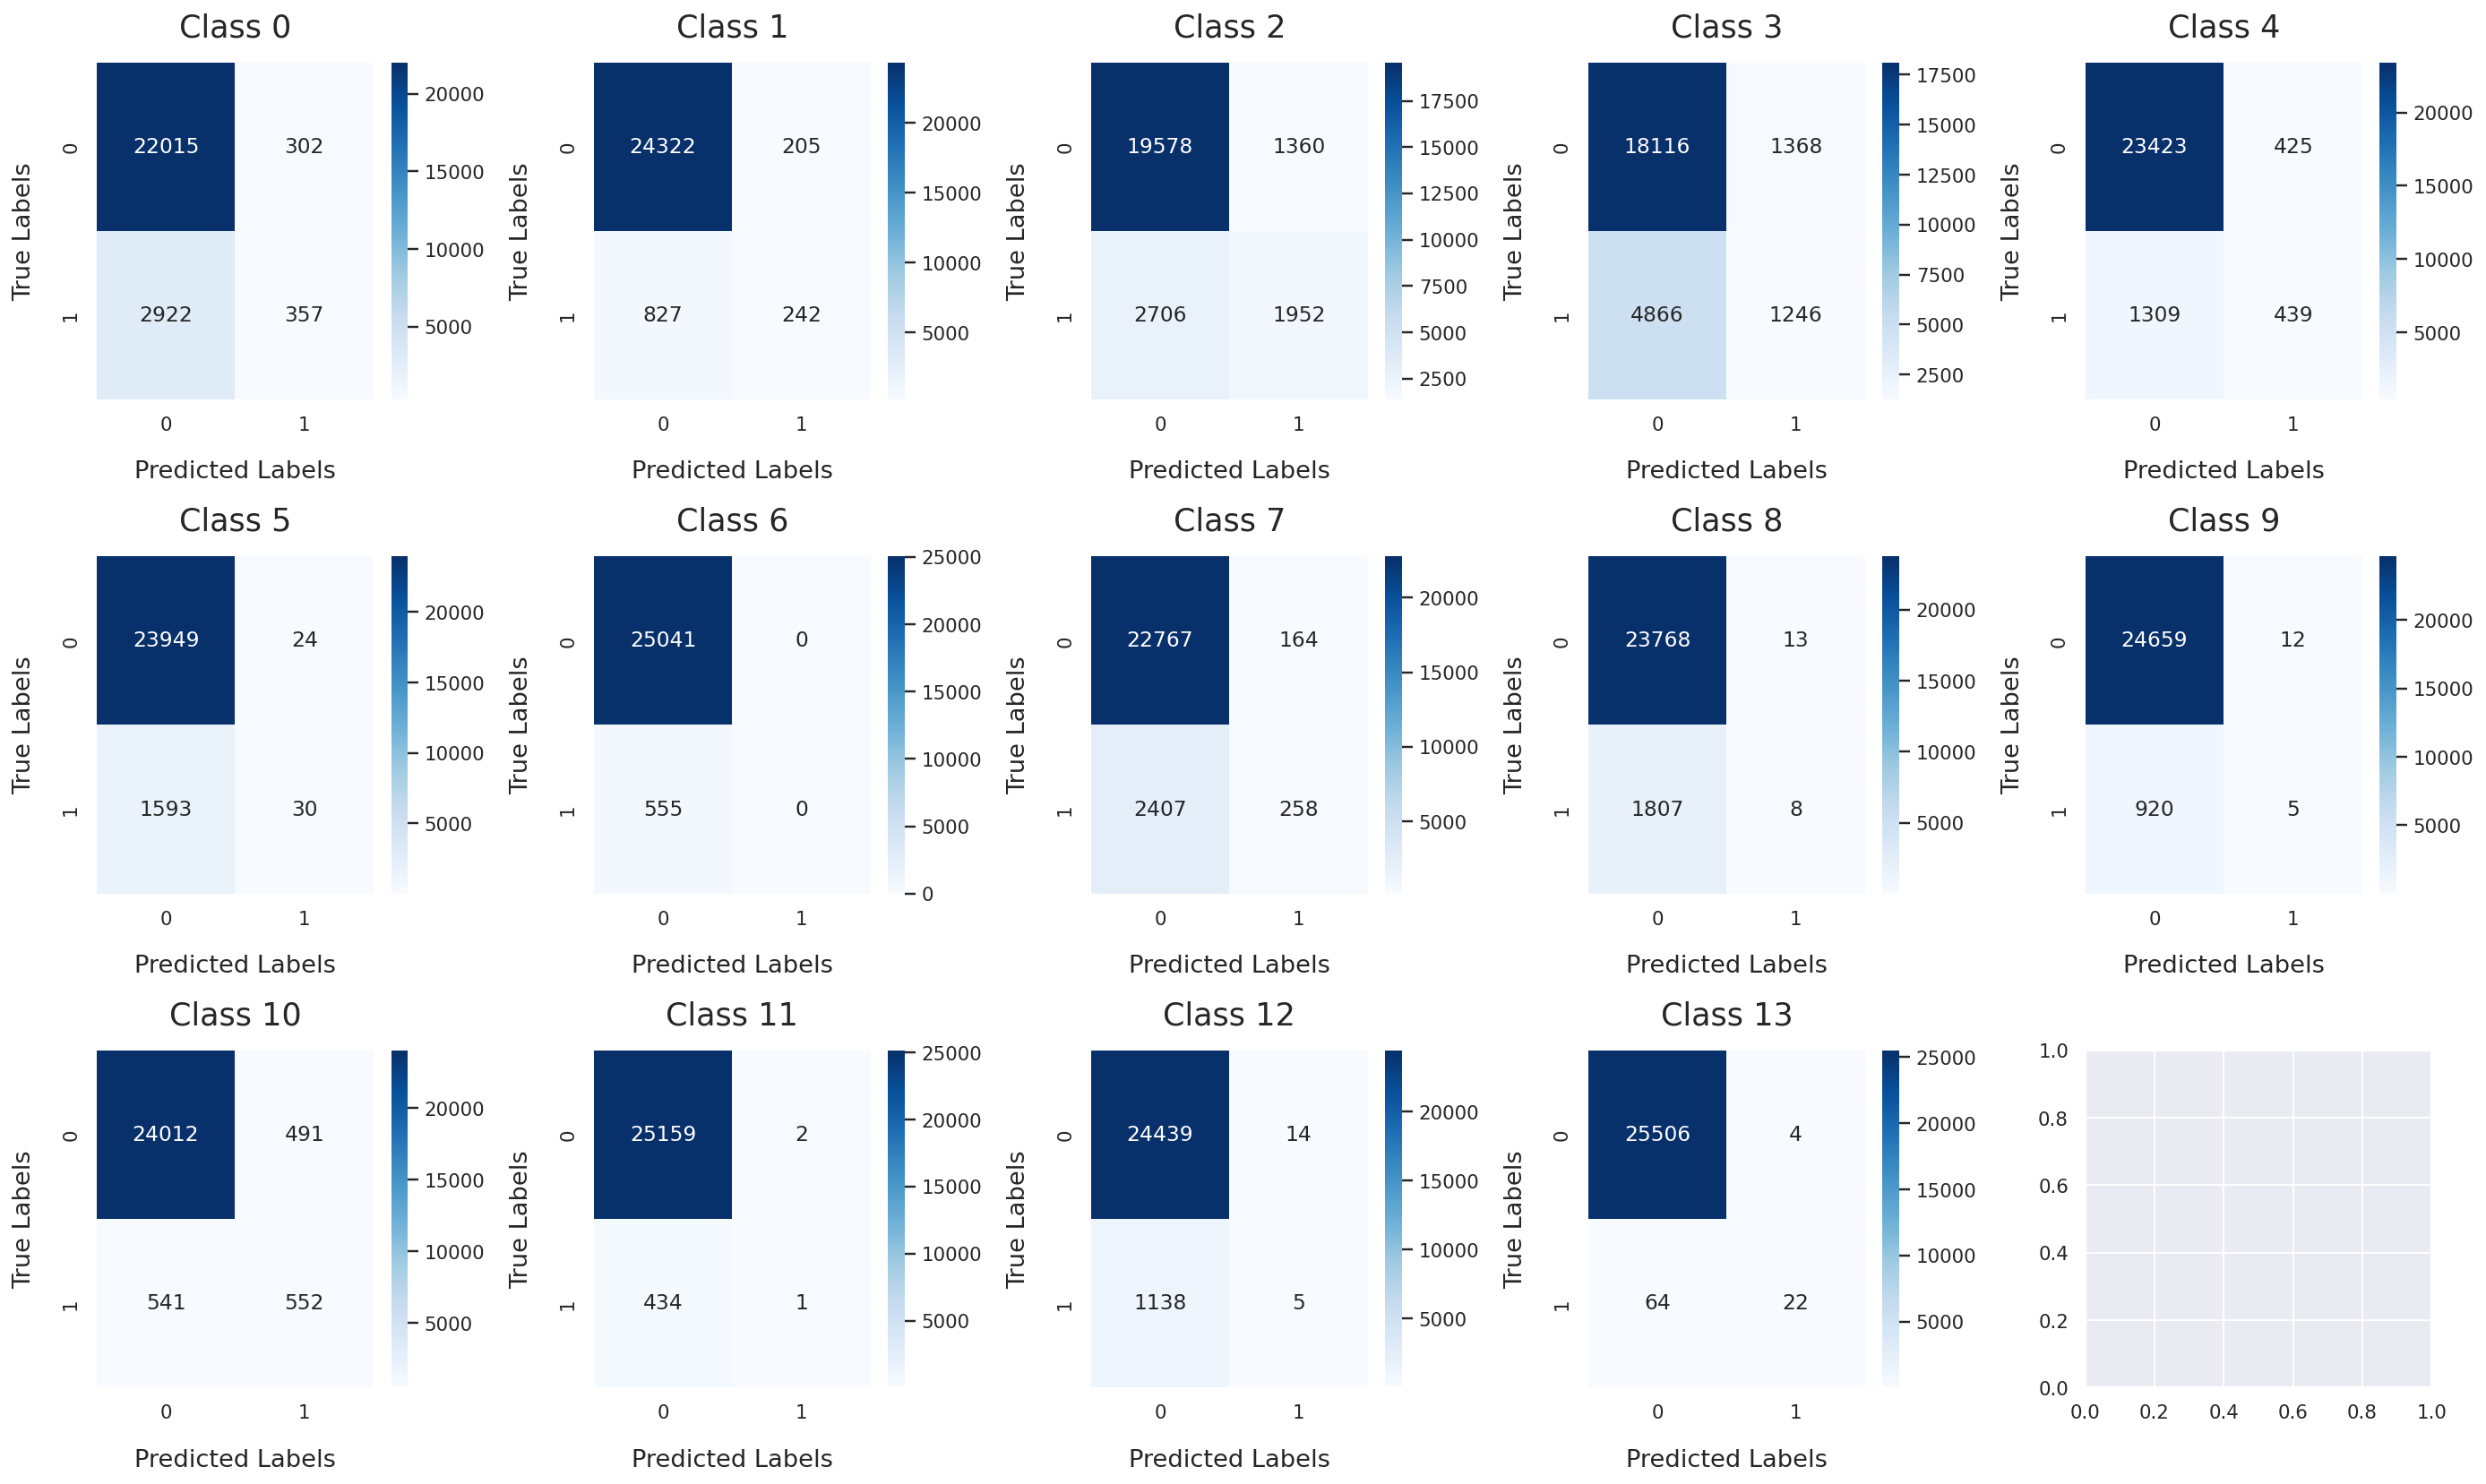

In [22]:
# Compute confusion matrices for each class
mcm = multilabel_confusion_matrix(all_labels, predictions)

# Plot each confusion matrix
# Adjust the layout based on the number of classes
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()
for i, cm in enumerate(mcm):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{labels[i]}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()